# Принятие решений в бизнесе.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Описание проекта

Вы — аналитик крупного интернет-магазина. 

Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

### Цель: приоритизировать гипотезы, провести анализ результатов A/B теста.

### Описание данных

### Данные для первой части

Файл `/datasets/hypothesis.csv`. 
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

### Данные для второй части

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

# 1. Подготовка данных.

In [3]:
try:
    hypothesis_data = pd.read_csv(r'datasets/hypothesis.csv')
except:
    hypothesis_data = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
hypothesis_data.columns = hypothesis_data.columns.str.lower()
hypothesis_data

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
try:
    orders = pd.read_csv(r'datasets/orders.csv')
    visitors = pd.read_csv(r'datasets/visitors.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
display(orders.head())
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [7]:
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
orders.duplicated().sum()

0

In [9]:
visitors.duplicated().sum()

0

In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

- **Выявлен столбец дата с типом object в таблицах orders и visitors. Приведен к типу date.**
- **Пропусков, явных дубликатов не выявлено.**

# 2. Приоритизация гипотез.

Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют.

**ICE** (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач:

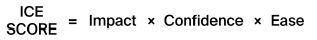

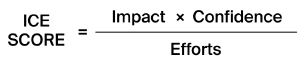

У этого метода есть модификация **RICE** (R от англ. reach, «охват»):

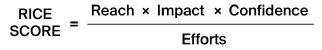

- `Reach` — (охват) скольких пользователей затронет изменение, которое вы хотите внести;
- `Impact` — (влияние) насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- `Confidence` — (уверенность) насколько вы уверены, что это изменение повлияет на пользователей именно так;
- `Efforts` — (затраты) сколько стоит протестировать эту гипотезу.
- `Ease` - (легкость) насколько легко будет разрабатывать, тестировать и запускать эту фичу?

In [11]:
hypothesis_data['ice'] = (hypothesis_data['impact'] * hypothesis_data['confidence']) / hypothesis_data['efforts']
hypothesis_data[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).reset_index(drop=True)

,hypothesis,ice
0,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [12]:
hypothesis_data['rice'] = (hypothesis_data['reach'] * hypothesis_data['impact'] * hypothesis_data['confidence'])\
                            / hypothesis_data['efforts']
hypothesis_data[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).reset_index(drop=True)

,hypothesis,rice
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",16.2
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Согласно оценке **ICE** в первую очередь следует проверить такие гипотезы как:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

А в модификации  **RICE**:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


**В модификации оценки  `RICE` присутствует такой параметр, как охват пользователей, который помогает определить важность гипотезы на массового пользователя. Выгоднее за условно одно действие привлечь как можно больше пользователей.**

# 3. Анализ A/B-теста

In [13]:
def norm_or_not_norm(arr, alpha=0.05):
    results = st.shapiro(arr)
    p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

In [14]:
norm_or_not_norm(list(orders.revenue))

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [15]:
norm_or_not_norm(list(visitors.visitors))

p-значение:  0.00202026404440403
Отвергаем нулевую гипотезу: распределение не нормально


**Распределения стоимости заказов и количества пользователей не являются нормальными.**

## 3.1. Стабильность кумулятивных метрик

### 3.1.1. График кумулятивной выручки по группам.

In [16]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий. 
# Этот код работает так, будто мы ежедневно считали результаты тестирования до выбранного 
# дня включительно и сохраняли их в строках таблицы ordersAggregated. 
ordersAggregated = (datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg(
        {'date' : 'max', 
         'group' : 'max', 
         'transaction_id' : 'nunique', 
         'visitor_id' : 'nunique', 
         'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# Аналогично получим агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = (datesGroups
      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
      .agg(
          {'date' : 'max', 
           'group' : 'max', 
           'visitors' : 'sum'}), axis=1)
      .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#присваиваем ее столбцам понятные названия
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


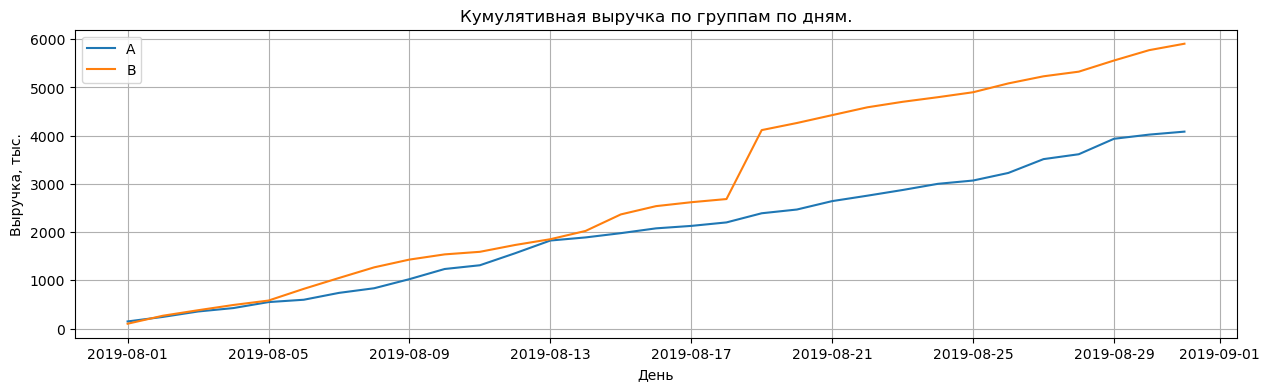

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'visitors']]


plt.figure(figsize=(15,4))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/1000, label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/1000, label='B')

plt.legend()
plt.title("Кумулятивная выручка по группам по дням.")
plt.xlabel('День')
plt.ylabel('Выручка, тыс.')
plt.grid();

**Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.**

**Однако график выручки  группы "B" в нескольких точках резко растёт. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке для группы "B".**

### 3.1.2. График кумулятивного среднего чека по группам.

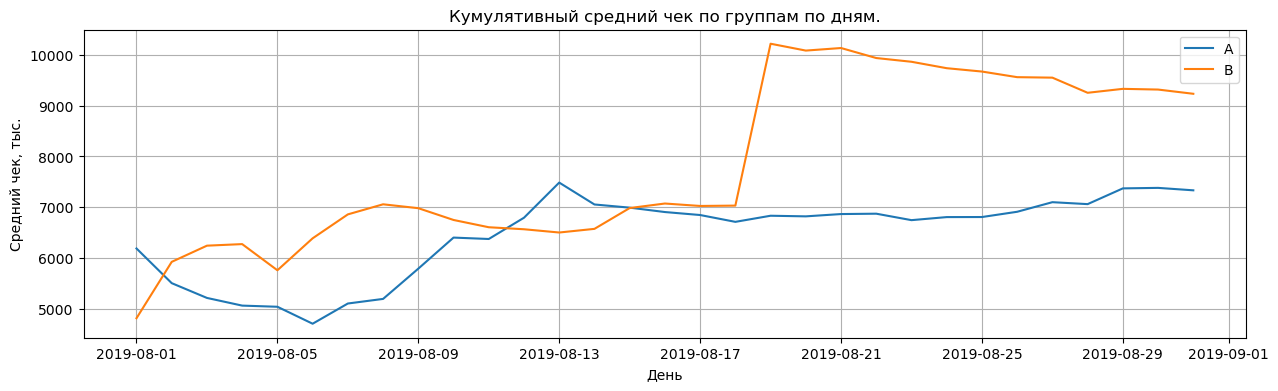

In [18]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.title("Кумулятивный средний чек по группам по дням.")
plt.xlabel('День')
plt.ylabel('Средний чек, тыс.')
plt.grid();

- **Неравномерно увеличение кумулятивного среднего чека для группы 'B' наблюдается в начале теста.**
- **Резкий скачек кумулятивного среднего чека для группы 'B' в середине теста одним днем, а затем плавное падение. Ошибка данных или очень крупный заказ?**
- **Падение кумулятивного среднего чека для группы 'А'наблюдается в начале теста, затем относительно резкий рост. График просел ввиду отсутствия данных за эти дни или снижения продаж? Отсутвие ощутимого роста или падения во второй половине теста. График просел ввиду отсутствия данных за эти дни или снижения продаж?**

### 3.1.3. График относительного изменения кумулятивного среднего чека группы B к группе A.

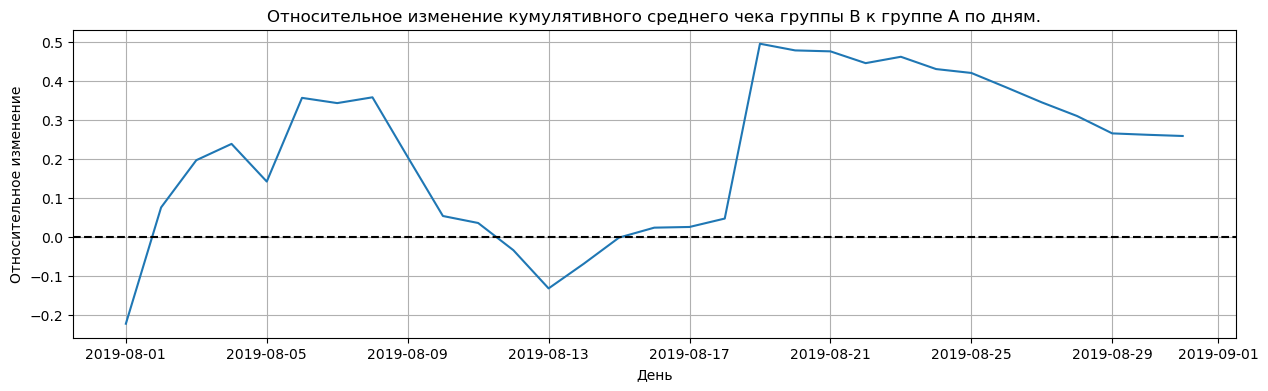

In [19]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,4))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A по дням.")
plt.xlabel('День')
plt.ylabel('Относительное изменение')
plt.grid();

**Результаты теста значительно и резко менялись в несколько дат. Видимо тогда и были совершены аномальные заказы.**

### 3.1.4. График кумулятивного среднего количества заказов на посетителя по группам

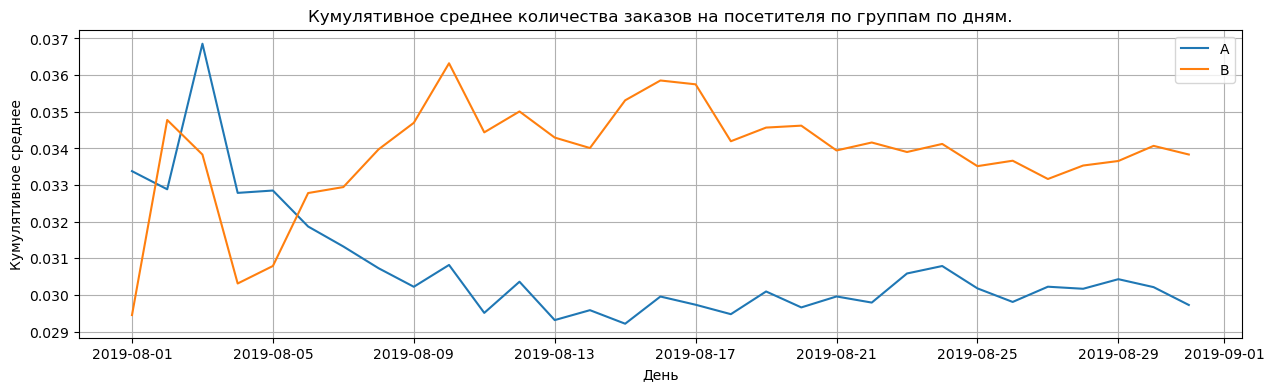

In [20]:
plt.figure(figsize=(15,4))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['orders']/cumulativeRevenueA['visitors'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders']/cumulativeRevenueB['visitors'], label='B')

plt.legend()
plt.title("Кумулятивное среднее количества заказов на посетителя по группам по дням.")
plt.xlabel('День')
plt.ylabel('Кумулятивное среднее')
plt.grid();

- **В начале теста группы показывают рост.**
- **Группа В лидирует не смортря на стабильное снижение среднего количества заказов при росте аналогичного показателя у группы А.**

### 3.1.5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

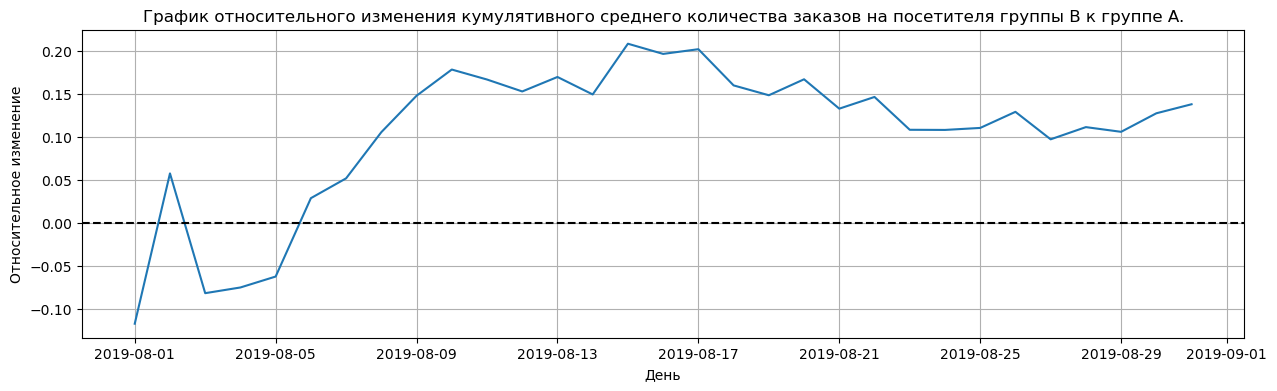

In [21]:
plt.figure(figsize=(15,4))

plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['ordersB']/mergedCumulativeRevenue['visitorsB'])
         /(mergedCumulativeRevenue['ordersA']/mergedCumulativeRevenue['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.")
plt.ylabel("Относительное изменение")
plt.xlabel('День')
plt.grid();


**С небольшими изменениями в начале теста группа В однозначно лучше группы А по среднему количеству заказов на посетителя. Однако постепенно теряет свое преимущество со временем.**

## 3.2. Анализ выбросов и всплесков: крайние значения данных.

### 3.2.1. Точечный график количества заказов по пользователям.

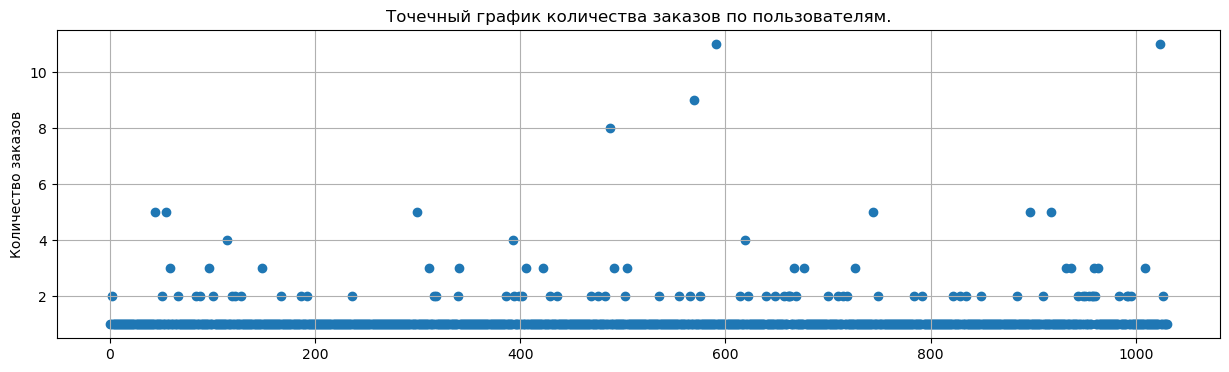

In [22]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(15,4))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.grid()
plt.title("Точечный график количества заказов по пользователям.")
plt.ylabel("Количество заказов");

- **В основном пользователи совершают 1 заказ.**
- **Много пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.**

### 3.2.2. Граница для определения аномальных заказов.

In [23]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Принято отсеивать от 1% до 5% наблюдений с крайними значениями.

**Не более 5% пользователей оформляли больше чем 2 заказов. И 1% пользователей заказывали более 4 раз. 
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.**

### 3.2.3. Точечный график стоимостей заказов.

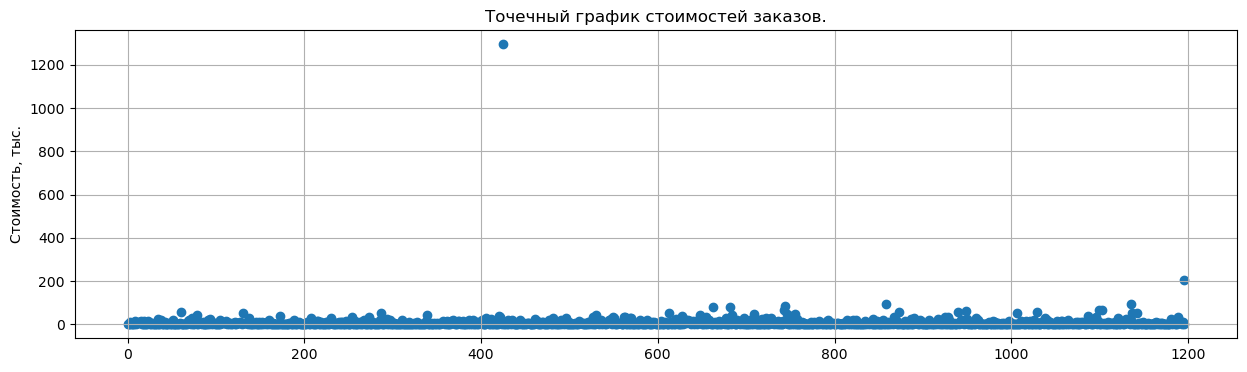

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, orders['revenue']/1000)
plt.grid()
plt.title("Точечный график стоимостей заказов.")
plt.ylabel("Стоимость, тыс.");

- **Наблюдаются два выбоса в 200 000 и 1 300 000. Явно их не стоит учитывать.**
- **Большинство заказов стоимостю до 30 000.**

### 3.2.4. Граница для определения аномальных стоимостей.

In [25]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Заказаы стоимостью выще 28 000,00 следует не учитывать.

## 3.3. Статистическая значимость различий.

### 3.3.1. Подготовка данных для расчета p-value. 

**Создание таблицы с накопительными данными по заказам для каждой группы.**

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

**Создание таблицы с накопительными данными по заказам для каждой группы.**

In [27]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

**Создание объединённой таблицы:**

In [28]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


названия столбцов данных:

        date — дата;
        ordersPerDateA — количество заказов в выбранную дату в группе A;
        revenuePerDateA — суммарная выручка в выбранную дату в группе A;
        ordersPerDateB — количество заказов в выбранную дату в группе B;
        revenuePerDateB — суммарная выручка в выбранную дату в группе B;
        ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
        revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
        ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
        revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
        visitorsPerDateA — количество пользователей в выбранную дату в группе A;
        visitorsPerDateB — количество пользователей в выбранную дату в группе B;
        visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
        visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

**Создание таблиц для пользователей групп совершивших хотя бы одну покупку:**

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

**Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.**

Переменная sampleA должна состоять из двух частей:
- Список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'].
- Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах: data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']).
  
Дальше передадим аргумент, сообщающий, что объекты Series нужно объединить по строкам (то есть записать подряд)

о же делаем для `sampleB` и получаем:
  

In [30]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders',),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),
    ],
    axis=0,
)

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders.

Объединим их в таблице abnormalUsers.

**Узнаем, сколько всего аномальных пользователей атрибутом shape.**

In [31]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], 95))]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], 95))]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], 95))]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers.head())
abnormalUsers.shape[0]

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

74

74 аномальных пользователя.

**подготовим выборки количества заказов по пользователям по группам теста:**

In [32]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders',),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders',),
    ],
    axis=0,
) 

In [33]:
def p_value(p_value, alpha=0.05):
    print(f'p-значение: {p_value:.3f}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

## 3.4. Выбор метода для статического теста.

Проверка значений выборки на нормальность критерием Шапиро-Уилко.

In [34]:
norm_or_not_norm(sampleA)

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


D:\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [35]:
norm_or_not_norm(sampleB)

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [36]:
norm_or_not_norm(orders[orders['group']=='A']['revenue'])

p-значение:  1.739723833199812e-34
Отвергаем нулевую гипотезу: распределение не нормально


In [37]:
norm_or_not_norm(orders[orders['group']=='B']['revenue'])

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Распределение не является нормальным, следовательно воспользуемся статическим тестом Манна-Уитни (U-критерий).

## 3.5. Статистическая значимость.

### 3.5.1. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Нулевая: различий в среднем количестве заказов между группами нет.  
Альтернативная: различия в среднем количестве заказов между группами есть.

In [38]:
p_value(st.mannwhitneyu(sampleA, sampleB)[1])

p-значение: 0.017
Отвергаем нулевую гипотезу


In [39]:
# относительный прирост среднего числа заказов группы B
print("относительный прирост среднего числа заказов группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

относительный прирост среднего числа заказов группы B: 0.138


**Различия в среднем количестве заказов между группами есть.**

### 3.5.2. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Нулевая: различий  в среднем чеке заказа между группами нет.  
Альтернативная: различия в среднем чеке заказа между группами есть.

In [40]:
p_value(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                 orders[orders['group']=='B']['revenue'])[1])

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу


In [41]:
print('относительный прирост среднего чека группы B: {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

относительный прирост среднего чека группы B: 0.259


**Различий в среднем чеке заказа между группами нет.**

### 3.5.3. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Нулевая: различий в среднем количестве заказов между группами нет.  
Альтернативная: различия в среднем количестве заказов между группами есть.

In [42]:
p_value(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

p-значение: 0.013
Отвергаем нулевую гипотезу


In [43]:
print('относительный прирост среднего числа заказов группы B: {0:.3f}'.format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1))

относительный прирост среднего числа заказов группы B: 0.173


**Различия в среднем количестве заказов между группами есть.**

### 3.5.4. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Нулевая: различий в среднем чеке заказа между группами нет.  
Альтернативная: различия в среднем чеке заказа между группами есть.

In [44]:
p_value(st.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'],
        )[1]
    )

p-значение: 0.738
Не получилось отвергнуть нулевую гипотезу


In [45]:
print(
    "относительный прирост среднего чека группы B: {0:.3f}".format(
        orders[np.logical_and(orders['group'] == 'B',
                              np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'].mean()
        - 1
    )
) 

относительный прирост среднего чека группы B: -0.020


**Различий в среднем чеке заказа между группами нет.**

## Вывод.

В проекте проводится анализ:  
- стабильности кумулятивных метрик (выручки, среднего чека, количества заказов) по группам.
- относительного изменения кумулятивных метрик группы B к группе A.
- выбросов и всплесков, определяется граница для определения аномальных пользователей.

Рассчитывается статистическая значимость различий в среднем количестве заказов на посетителя и среднем чеке между группами по «сырым» и «очищенным» данным. Проверка проводится критерием критерием Манна-Уитни. 


## На основании статических тестов `Различия в среднем количестве заказов между группами есть.` и `Различий в среднем чеке заказа между группами нет.`  принято решение остановить тест и зафиксировать победу группы B. Относительный прирост среднего числа заказов группы B: 17%.